### This is the one 

Libraries to be imported

In [50]:
import gurobipy as gp
from gurobipy import GRB
import math
import matplotlib.pyplot as plt
import numpy as np


In [59]:
# Time horizon
T = range(24)  # 24-hour horizon

# Parameters
np.random.seed(42)
base_load = 100 + np.cumsum(np.random.randn(len(T)) * 5)  # Base load around 100 MW

# Add variability for day and night usage
daytime_boost = np.array([15 if 8 <= t <= 20 else 0 for t in T])
Load = {t: max(50, int(base_load[t] + daytime_boost[t])) for t in T}

# Cooling load as a function of Load, e.g., 20% of the Load
CoolingLoad = {t: int(0.2 * Load[t]) for t in T}

grid_emissions = {t: 0.37 for t in T}  # tCO2/MWh
grid_cost = {t: 0.13 for t in T}  # $/kWh


# Grid Dependent DC

In [60]:
import gurobipy as gp
from gurobipy import GRB

model_grid_only = gp.Model("Grid_Only_DataCenter")

# Decision variable: how much to draw from grid at each time step
grid_power = model_grid_only.addVars(T, name="GridPower", lb=0)

# Objective: minimize total grid cost
model_grid_only.setObjective(
    gp.quicksum(grid_cost[t] * grid_power[t] for t in T),
    GRB.MINIMIZE
)

# Constraint: must meet total load (Load + CoolingLoad) at each time
for t in T:
    model_grid_only.addConstr(
        grid_power[t] >= Load[t] + CoolingLoad[t],
        name=f"DemandConstraint_{t}"
    )

model_grid_only.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 24 rows, 24 columns and 24 nonzeros
Model fingerprint: 0xcded0690
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 24 rows and 24 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1756000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.175600000e+02


In [61]:
# Total cost from the objective value
total_cost_grid_only = model_grid_only.ObjVal

# Total emissions (kg CO₂)
total_emissions_grid_only = sum(
    grid_emissions[t] * grid_power[t].X for t in T
)

print(f"Total Cost (Grid Only): ${total_cost_grid_only:,.2f}")
print(f"Total Emissions (Grid Only): {total_emissions_grid_only:,.2f} kg CO₂")


Total Cost (Grid Only): $417.56
Total Emissions (Grid Only): 1,188.44 kg CO₂


# Autonomous DC

Defining natural parameters

In [ ]:

eta_battery_charge = 0.9
eta_battery_discharge = 0.9
eta_H2_charge = 0.6
eta_H2_discharge = 0.6

solar_capex = 1000  # $/kW
wind_capex = 1500
battery_capex = 400  # $/kWh
H2_capex = 1000

CO2e_cap = 500  # tCO2 (construction)


# Solar irradiance, how much sun we have
irradiance = {
    t: max(0, math.sin(math.pi * (t - 6) / 12))  # Peak at t=12, zero at t=6 and t=18
    for t in T
}
solar_conversion = 1  # typical value is around 0.9 to 1

# wind Factor, how much we have, and how efficiently can turbines extract wind
wind_factor = {
    t: 0.5 + 0.2 * math.sin(math.pi * (t - 4) / 12)  # peak around 4 PM, dip at 4 AM
    for t in T
}
wind_conversion = 1  # turbine conversion efficiency


Visualizations

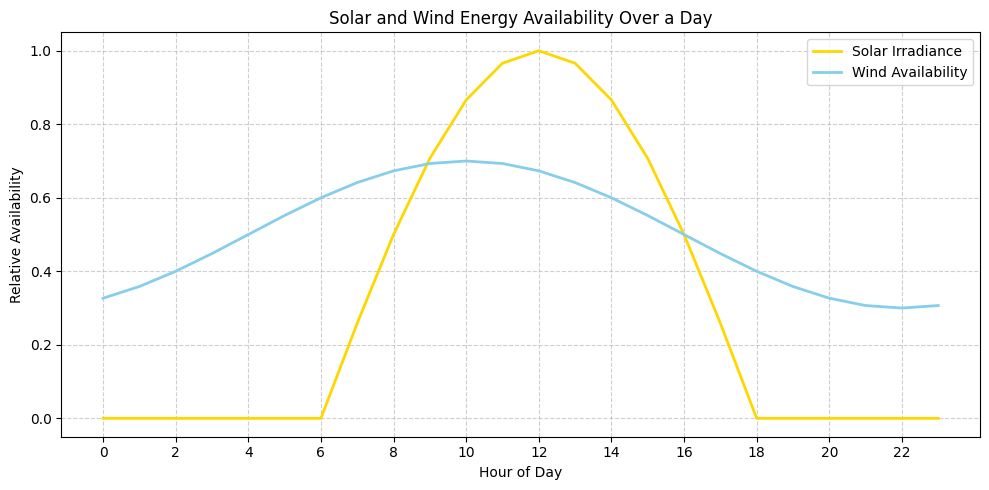

In [52]:
# Plotting

plt.figure(figsize=(10, 5))
plt.plot(T, irradiance.values(), label='Solar Irradiance', color='gold', linewidth=2)
plt.plot(T, wind_factor.values(), label='Wind Availability', color='skyblue', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Relative Availability')
plt.title('Solar and Wind Energy Availability Over a Day')
plt.xticks(range(0, 24, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

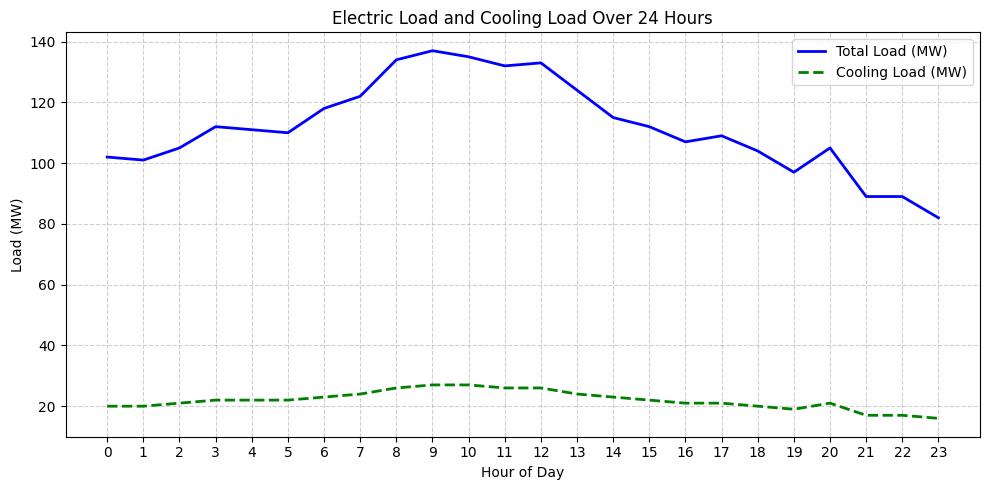

In [53]:
hours = list(Load.keys())
load_values = list(Load.values())
cooling_values = list(CoolingLoad.values())
plt.figure(figsize=(10, 5))
plt.plot(hours, load_values, label='Total Load (MW)', color='blue', linewidth=2)
plt.plot(hours, cooling_values, label='Cooling Load (MW)', color='green', linestyle='--', linewidth=2)

plt.title('Electric Load and Cooling Load Over 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Load (MW)')
plt.xticks(range(0, 24, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Optimization problem formulation

Decision Variables

In [54]:

# Create model
m = gp.Model("DataCenterEnergyOptimization")


Pbattery_charge = m.addVars(T, name="Pbatt_charge", lb=0)
Pbattery_discharge = m.addVars(T, name="Pbatt_discharge", lb=0)
PH2_charge = m.addVars(T, name="PH2_charge", lb=0)
PH2_discharge = m.addVars(T, name="PH2_discharge", lb=0)

S_battery = m.addVars(T, name="Sbatt", lb=0)
S_H2 = m.addVars(T, name="SH2", lb=0)

Cap_solar = m.addVar(name="CapSolar", lb=0)
Cap_wind = m.addVar(name="CapWind", lb=0)
Cap_battery = m.addVar(name="CapBattery", lb=0)
Cap_H2 = m.addVar(name="CapH2", lb=0)
# Replace with computed values using Cap_solar
Psolar = {t: m.addVar(lb=0, name=f"Psolar_{t}") for t in T}

for t in T:
    m.addConstr(Psolar[t] == Cap_solar * irradiance[t] * solar_conversion, name=f"PsolarModel_{t}")
Pgrid = m.addVars(T, name="Pgrid", lb=0)

Pwind = {t: m.addVar(lb=0, name=f"Pwind_{t}") for t in T}


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Constraints

In [55]:


# Add constraints linking Pwind[t] to Cap_wind via wind factor
for t in T:
    m.addConstr(Pwind[t] == Cap_wind * wind_factor[t] * wind_conversion, name=f"PwindModel_{t}")

# Energy balance constraint
for t in T:
    m.addConstr(
        Load[t] + CoolingLoad[t] ==
        Pgrid[t] +
        Psolar[t] +
        Pwind[t] +
        Pbattery_discharge[t] * eta_battery_discharge +
        PH2_discharge[t] * eta_H2_discharge -
        Pbattery_charge[t] / eta_battery_charge -
        PH2_charge[t] / eta_H2_charge,
        name=f"EnergyBalance_{t}"
    )

# Battery and hydrogen storage dynamics
for t in T:
    if t == 0:
        m.addConstr(S_battery[t] == 0, name="InitBattery")
        m.addConstr(S_H2[t] == 0, name="InitH2")
    else:
        m.addConstr(
            S_battery[t] == S_battery[t-1] +
            Pbattery_charge[t] * eta_battery_charge -
            Pbattery_discharge[t] / eta_battery_discharge,
            name=f"BatteryStorage_{t}"
        )
        m.addConstr(
            S_H2[t] == S_H2[t-1] +
            PH2_charge[t] * eta_H2_charge -
            PH2_discharge[t] / eta_H2_discharge,
            name=f"H2Storage_{t}"
        )

# Storage capacity constraints
for t in T:
    m.addConstr(S_battery[t] <= Cap_battery, name=f"BatteryCap_{t}")
    m.addConstr(S_H2[t] <= Cap_H2, name=f"H2Cap_{t}")


Objective function and solving

In [56]:

# Objective components
total_emissions = CO2e_cap + gp.quicksum(Pgrid[t] * grid_emissions[t] for t in T)
total_cost = (
    solar_capex * Cap_solar +
    wind_capex * Cap_wind +
    battery_capex * Cap_battery +
    H2_capex * Cap_H2 +
    gp.quicksum(Pgrid[t] * grid_cost[t] * 1000 for t in T)  # $/kWh × MWh = $1000
)


alpha = 0.5
# Objective function: weighted sum of emissions and cost
m.setObjective(alpha * total_emissions + (1 - alpha) * total_cost, GRB.MINIMIZE)

# Solve
m.optimize()

# Output results
if m.status == GRB.OPTIMAL:
    print(f"Objective Value: {m.ObjVal:.2f}")
    for t in T:
        print(f"Hour {t}: Grid={Pgrid[t].X:.2f} MW, Solar={Psolar[t].X:.2f} MW, Wind={Pwind[t].X:.2f} MW")
    print(f"Installed Solar Capacity: {Cap_solar.X:.2f} kW")
    print(f"Installed Wind Capacity: {Cap_wind.X:.2f} kW")
    print(f"Installed Battery Capacity: {Cap_battery.X:.2f} kWh")
    print(f"Installed H2 Capacity: {Cap_H2.X:.2f} kWh")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 168 rows, 220 columns and 533 nonzeros
Model fingerprint: 0xe09f1dfa
Coefficient statistics:
  Matrix range     [3e-01, 2e+00]
  Objective range  [7e+01, 8e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 55 rows and 60 columns
Presolve time: 0.01s
Presolved: 113 rows, 160 columns, 404 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5000000e+02   2.999250e+03   0.000000e+00      0s
      77    1.9918653e+05   0.000000e+00   0.000000e+00      0s

Solved in 77 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.991865293e+05
Objective Value: 199186.53
Hour 0: Grid=0.00 MW, Solar=0.00 MW, Wind=74.38 MW
Hour 1: Grid=39.38 MW, Solar=0.00 MW, W